<a href="https://colab.research.google.com/github/WNderitu/Malaria-Parasite-Detector-Showcase/blob/main/3_data_preparation_for_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plasmodium Vivax (malaria) parasite detector and counter**

**Notebook 3: Data Preparation for Hyperparameter tuning Notebook**

- YOLOv8n model variant/size

In [1]:
from google.colab import drive

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully!


## **4.0 Install & import required libraries**

In [2]:
!pip install matplotlib --quiet

In [3]:
!pip install Pillow --quiet #installing PILLOW LIBRARY

In [4]:
!pip install imagehash --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.3 MB/s eta 0:00:00


In [5]:
!pip install pyyaml --quiet

In [34]:
import json
import os
import random
import shutil # For copying images, creating directories
from PIL import Image # Import Image to get image dimensions
from pprint import pprint # for
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt # Import pyplot to plot images
import hashlib # find identical images
from collections import defaultdict
import numpy as np
import math # for mathematical calculations
import yaml # For generating data.yaml
from collections import Counter # Import Counter to get class counts
import pandas as pd
import matplotlib.patches as mpatches

## 4.0 Data Preparation after first model training

-------------------
## **Will entail:**
1. Step 1. Checking feasibility of removing difficult class by conducting:
  - Distribution analysis of images with Difficult class
  - Co_occurence analysis of Difficult class with other malaria parasite classes
  - Analysis of Bounding box dimesions for all classes.
2. Step 2. Create a folder for dataset with no 'Difficult' class
3. Step 3. Backing up original label files.
4. Step 4. Remappings class ID 3 (“difficult”) to 5 (“trophozoite”).
5. Step 5. Adjusting class weights for retraining.
4. Step 6. Updating data.yaml to reflect 6 classes
-------------------

## 4.1 Checking feasibility of removing difficult data class

### *Check distribution of images with 'difficult' class*

In [9]:
malaria_dataset_dir='/content/drive/MyDrive/yolov8_malaria_dataset'

difficult_class_id = 3

def analyze_difficult_class(labels_base_path, subsets, difficult_id):
    results = {}
    for subset in subsets:
        subset_path = os.path.join(labels_base_path, subset)
        images_with_difficult = 0
        total_difficult_instances = 0

        if not os.path.exists(subset_path):
            print(f"Warning: Labels directory for '{subset}' not found at {subset_path}")
            results[subset] = {'images_with_difficult': 0, 'total_difficult_instances': 0}
            continue

        for label_file_name in os.listdir(subset_path):
            if label_file_name.endswith('.txt'):
                label_file_path = os.path.join(subset_path, label_file_name)
                has_difficult_in_file = False
                difficult_instances_in_file = 0

                with open(label_file_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 0 and int(parts[0]) == difficult_id:
                            has_difficult_in_file = True
                            difficult_instances_in_file += 1

                if has_difficult_in_file:
                    images_with_difficult += 1
                    total_difficult_instances += difficult_instances_in_file

        results[subset] = {
            'images_with_difficult': images_with_difficult,
            'total_difficult_instances': total_difficult_instances
        }
    return results

# Define the base path for YOLOv8 labels
labels_base_path = os.path.join(malaria_dataset_dir, 'labels')
subsets = ['training', 'val', 'test']

# Perform the analysis
difficult_analysis_results = analyze_difficult_class(labels_base_path, subsets, difficult_class_id)

# Print the results
print(f"\nAnalysis of 'difficult' class (ID {difficult_class_id}) distribution:")
for subset, data in difficult_analysis_results.items():
    print(f"\nSubset: {subset.capitalize()}")
    print(f"  Number of images containing 'difficult' class: {data['images_with_difficult']}")
    print(f"  Total 'difficult' instances: {data['total_difficult_instances']}")


Analysis of 'difficult' class (ID 3) distribution:

Subset: Training
  Number of images containing 'difficult' class: 270
  Total 'difficult' instances: 345

Subset: Val
  Number of images containing 'difficult' class: 72
  Total 'difficult' instances: 96

Subset: Test
  Number of images containing 'difficult' class: 5
  Total 'difficult' instances: 5


Training: % of Total Annotations - ~2.45% of labels

Val: % of Total Annotations ~0.68% of labels

Test: % of Total Annotations - Negligible

Recommend: merge difficult class with trophozoite!

### *Visualize distribution of difficult class*

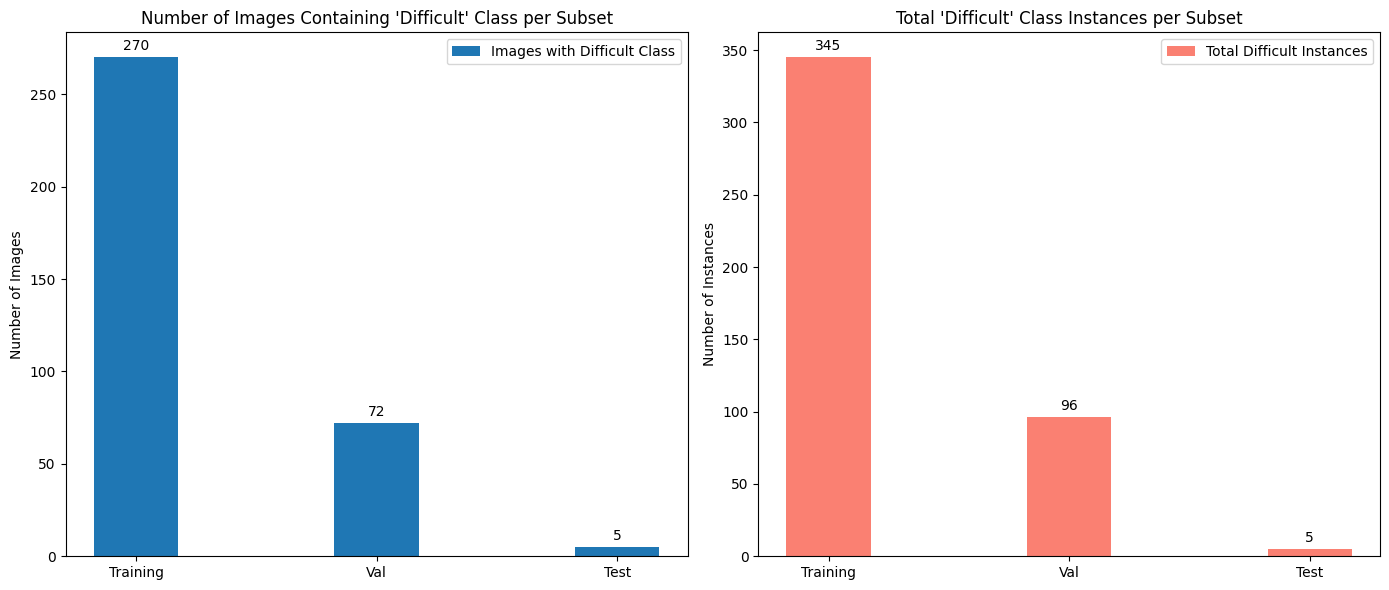

In [10]:
# Extract data from difficult_analysis_results
subsets = list(difficult_analysis_results.keys())
images_with_difficult = [difficult_analysis_results[subset]['images_with_difficult'] for subset in subsets]
total_difficult_instances = [difficult_analysis_results[subset]['total_difficult_instances'] for subset in subsets]

x = np.arange(len(subsets))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Number of Images containing 'difficult' class
rects1 = ax1.bar(x, images_with_difficult, width, label='Images with Difficult Class')
ax1.set_ylabel('Number of Images')
ax1.set_title('Number of Images Containing \'Difficult\' Class per Subset')
ax1.set_xticks(x)
ax1.set_xticklabels([s.capitalize() for s in subsets])
ax1.legend()

# Add labels on top of bars
for rect in rects1:
    height = rect.get_height()
    ax1.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Plot for Total 'difficult' instances
rects2 = ax2.bar(x, total_difficult_instances, width, label='Total Difficult Instances', color='salmon')
ax2.set_ylabel('Number of Instances')
ax2.set_title('Total \'Difficult\' Class Instances per Subset')
ax2.set_xticks(x)
ax2.set_xticklabels([s.capitalize() for s in subsets])
ax2.legend()

# Add labels on top of bars
for rect in rects2:
    height = rect.get_height()
    ax2.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

Training: % of Total Annotations - ~2.45% of labels

Val: % of Total Annotations ~0.68% of labels

Test: % of Total Annotations - Negligible

Recommend: merge difficult class with trophozoite!

### *Co_occurence pattern of difficult class with other classe*s

In [12]:
difficult_class_id = 3

# Re-define category_to_id here for self-containment
category_to_id = {
    "red blood cell": 0,
    "leukocyte": 1,
    "schizont": 2,
    "difficult": 3,
    "ring": 4,
    "trophozoite": 5,
    "gametocyte": 6
}

def analyze_difficult_co_occurrence(labels_base_path, subsets, difficult_id, id_to_category_map):
    co_occurrence_results = {}
    for subset in subsets:
        subset_path = os.path.join(labels_base_path, subset)
        co_occurring_classes = defaultdict(int)

        if not os.path.exists(subset_path):
            print(f"Warning: Labels directory for '{subset}' not found at {subset_path}")
            co_occurrence_results[subset] = {} # Empty result for this subset
            continue

        for label_file_name in os.listdir(subset_path):
            if label_file_name.endswith('.txt'):
                label_file_path = os.path.join(subset_path, label_file_name)
                has_difficult_in_file = False
                current_file_classes = set() # Store unique classes in the current file

                with open(label_file_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 0:
                            class_id = int(parts[0])
                            current_file_classes.add(class_id)
                            if class_id == difficult_id:
                                has_difficult_in_file = True

                if has_difficult_in_file:
                    # If 'difficult' is in this file, count all other classes present
                    for class_id in current_file_classes:
                        if class_id != difficult_id:
                            co_occurring_classes[class_id] += 1

        # Map class IDs to names for the results
        named_co_occurring_classes = {id_to_category_map.get(cid, f'Unknown_ID_{cid}'): count
                                      for cid, count in co_occurring_classes.items()}
        co_occurrence_results[subset] = dict(sorted(named_co_occurring_classes.items(), key=lambda item: item[1], reverse=True))

    return co_occurrence_results

# Create a reverse mapping from class ID to category name
id_to_category = {v: k for k, v in category_to_id.items()}

# Define the base path for YOLOv8 labels and subsets
labels_base_path = os.path.join(malaria_dataset_dir, 'labels')
subsets = ['training', 'val', 'test']

# Perform the co-occurrence analysis
co_occurrence_results = analyze_difficult_co_occurrence(labels_base_path, subsets, difficult_class_id, id_to_category)

# Print the results
print(f"\nClasses co-occurring with 'difficult' class (ID {difficult_class_id}):")
for subset, data in co_occurrence_results.items():
    print(f"\nSubset: {subset.capitalize()}")
    if data:
        for cls_name, count in data.items():
            print(f"  - {cls_name}: Found in {count} images containing 'difficult'")
    else:
        print("  No co-occurring classes found in images containing 'difficult'.")



Classes co-occurring with 'difficult' class (ID 3):

Subset: Training
  - red blood cell: Found in 270 images containing 'difficult'
  - trophozoite: Found in 133 images containing 'difficult'
  - gametocyte: Found in 37 images containing 'difficult'
  - ring: Found in 36 images containing 'difficult'
  - schizont: Found in 32 images containing 'difficult'
  - leukocyte: Found in 21 images containing 'difficult'

Subset: Val
  - red blood cell: Found in 72 images containing 'difficult'
  - trophozoite: Found in 34 images containing 'difficult'
  - schizont: Found in 13 images containing 'difficult'
  - ring: Found in 8 images containing 'difficult'
  - gametocyte: Found in 8 images containing 'difficult'
  - leukocyte: Found in 3 images containing 'difficult'

Subset: Test
  - red blood cell: Found in 5 images containing 'difficult'
  - gametocyte: Found in 2 images containing 'difficult'
  - trophozoite: Found in 1 images containing 'difficult'


### Co_occurence chart

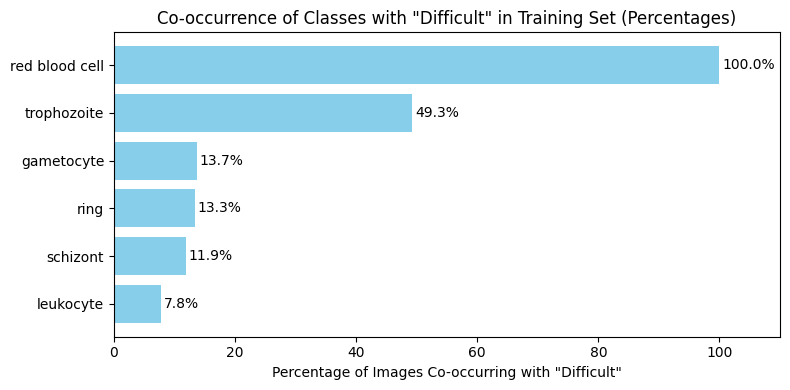

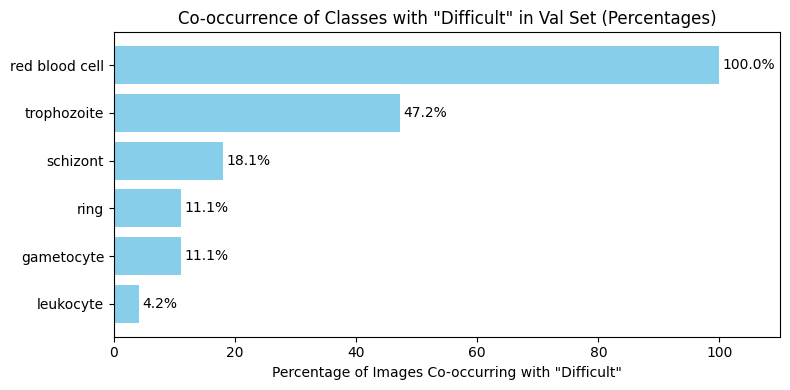

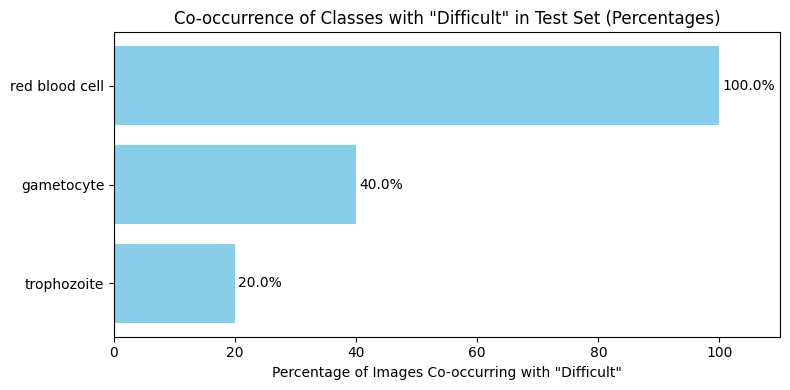

In [13]:
# Assuming co_occurrence_results and difficult_analysis_results are available from previous execution

for subset, data in co_occurrence_results.items():
    if not data:
        print(f"No co-occurring classes to visualize for subset: {subset.capitalize()}")
        continue

    classes = list(data.keys())
    raw_counts = list(data.values())

    # Get the total number of images containing 'difficult' for this subset
    total_difficult_images_in_subset = difficult_analysis_results[subset]['images_with_difficult']

    if total_difficult_images_in_subset == 0:
        print(f"No images with 'difficult' class in {subset.capitalize()} to calculate percentages.")
        continue

    # Calculate percentages
    percentages = [(count / total_difficult_images_in_subset) * 100 for count in raw_counts]

    # Sort by percentage in descending order for better readability
    sorted_data = sorted(zip(classes, percentages), key=lambda x: x[1], reverse=True)
    sorted_classes = [item[0] for item in sorted_data]
    sorted_percentages = [item[1] for item in sorted_data]

    # Create a bar chart for each subset
    fig, ax = plt.subplots(figsize=(8, 4))
    y_pos = np.arange(len(sorted_classes))
    ax.barh(y_pos, sorted_percentages, align='center', color='skyblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Percentage of Images Co-occurring with "Difficult"')
    ax.set_title(f'Co-occurrence of Classes with "Difficult" in {subset.capitalize()} Set (Percentages)')

    # Add percentages on the bars
    for i, v in enumerate(sorted_percentages):
        ax.text(v + 0.5, i, f'{v:.1f}%', color='black', va='center')

    plt.xlim(right=max(sorted_percentages) * 1.1) # Adjust x-axis limit for labels
    plt.tight_layout()
    plt.show()

1. Trophozoite - dominant co-occurring class. Found in 133/270 training images with “difficult” → nearly 50% overlap.
Also present in 34/72 validation images → consistent pattern. Confusion matrix from model training shows 43 misclassifications from “difficult” to trophozoite.
2. Ring and schizont co-occur less frequently. Ring: 36 training images. Schizont: 32 training images. These are secondary candidates for merging, but less compelling.
3. Red blood cells co-occur in all images
Expected, since RBCs are the background canvas for parasite detection.
4. Test set confirms minimal impact
Only 1 test image has both “difficult” and trophozoite. Removing or merging “difficult” won’t skew test evaluation.

### *Comparison & analysis of Bounding box dimesions for all classes.*

#### *Create image dimensions*

In [14]:
# Re-define malaria_subfolder_path and json paths as they were not in the kernel state
extract_dir_drive = '/content/drive/MyDrive/malaria_dataset'
malaria_subfolder_path = os.path.join(extract_dir_drive, 'malaria')
training_json = os.path.join(malaria_subfolder_path, 'training.json')
test_json = os.path.join(malaria_subfolder_path, 'test.json')

def load_image_dimensions(json_file_path):
    dimensions_map = {}
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    for entry in data:
        filename = os.path.basename(entry['image']['pathname'])
        width = entry['image']['shape']['c']
        height = entry['image']['shape']['r']
        dimensions_map[filename] = (width, height)
    return dimensions_map

# Load dimensions from training and test JSON files
training_dimensions = load_image_dimensions(training_json)
test_dimensions = load_image_dimensions(test_json)

# Combine the dictionaries
image_dimensions_map = {**training_dimensions, **test_dimensions}

# Print the first 5 key-value pairs
print("First 5 image dimensions:")
for i, (filename, dims) in enumerate(image_dimensions_map.items()):
    if i >= 5:
        break
    print(f"  {filename}: {dims}")

# Print the total number of unique images
print(f"\nTotal unique images loaded with dimensions: {len(image_dimensions_map)}")

First 5 image dimensions:
  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png: (1600, 1200)
  6b14c855-8561-417c-97a4-63fa552842fd.png: (1600, 1200)
  13099edb-35d9-438f-b093-2cf2ebf9d255.png: (1600, 1200)
  2559636b-f01a-4414-93da-210c3b12d153.png: (1600, 1200)
  0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png: (1600, 1200)

Total unique images loaded with dimensions: 1151


#### *Extract Bounding Box Dimensions for All Classes*

In [15]:
# 1. Initialize an empty dictionary, all_classes_bbox_dimensions, using collections.defaultdict(list)
all_classes_bbox_dimensions = defaultdict(list)

# 2. Define labels_base_path using malaria_dataset_dir and the 'labels' subdirectory.
labels_base_path = os.path.join(malaria_dataset_dir, 'labels')

# 3. Define a list of subsets as 'training', 'val', and 'test'.
subsets = ['training', 'val', 'test']

# 4. Iterate through each subset:
for subset in subsets:
    subset_labels_path = os.path.join(labels_base_path, subset)

    # b. Check if the subset_labels_path exists; if not, print a warning and continue to the next subset.
    if not os.path.exists(subset_labels_path):
        print(f"Warning: Labels directory for '{subset}' not found at {subset_labels_path}")
        continue

    # c. Iterate through each .txt label_file_name in the subset_labels_path.
    for label_file_name in os.listdir(subset_labels_path):
        if label_file_name.endswith('.txt'):
            # d. From the label_file_name, derive the corresponding image_filename (trying both '.png' and '.jpg' extensions).
            image_filename_png = os.path.splitext(label_file_name)[0] + '.png'
            image_filename_jpg = os.path.splitext(label_file_name)[0] + '.jpg'

            img_width, img_height = None, None
            current_image_filename = None

            if image_filename_png in image_dimensions_map:
                current_image_filename = image_filename_png
                img_width, img_height = image_dimensions_map[image_filename_png]
            elif image_filename_jpg in image_dimensions_map:
                current_image_filename = image_filename_jpg
                img_width, img_height = image_dimensions_map[image_filename_jpg]

            # e. Check if the image_filename exists as a key in the image_dimensions_map.
            # i. If it exists, retrieve the img_width and img_height.
            # ii. If not, print a warning and skip the current label file.
            if img_width is None or img_height is None:
                print(f"Warning: Image dimensions not found for {os.path.splitext(label_file_name)[0]}. Skipping label file {label_file_name}.")
                continue

            label_file_path = os.path.join(subset_labels_path, label_file_name)
            # f. Open the label_file_path.
            with open(label_file_path, 'r') as f:
                # g. For each line in the label file:
                for line in f:
                    parts = line.strip().split()
                    # i. Split the line into parts.
                    # ii. If there are 5 parts, extract the class_id, x_center_norm, y_center_norm, width_norm, and height_norm.
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])

                        # iii. Calculate the absolute bbox_width by multiplying width_norm with img_width.
                        bbox_width = width_norm * img_width
                        # iv. Calculate the absolute bbox_height by multiplying height_norm with img_height.
                        bbox_height = height_norm * img_height

                        # v. Append the (bbox_width, bbox_height) tuple to the list associated with class_id in all_classes_bbox_dimensions.
                        all_classes_bbox_dimensions[class_id].append((bbox_width, bbox_height))

# 5. Print the total number of unique classes for which bounding box dimensions were collected.
print(f"\nTotal unique classes with collected bounding box dimensions: {len(all_classes_bbox_dimensions)}")

# 6. Create a reverse mapping from class_id to category_name using id_to_category based on the category_to_id dictionary.
id_to_category = {v: k for k, v in category_to_id.items()}

# 7. Iterate through all_classes_bbox_dimensions and for each class_id, print the class_name and the total number of bounding boxes collected.
print("\nNumber of bounding boxes collected per class:")
for class_id in sorted(all_classes_bbox_dimensions.keys()):
    class_name = id_to_category.get(class_id, f'Unknown_Class_{class_id}')
    num_bboxes = len(all_classes_bbox_dimensions[class_id])
    print(f"  - {class_name} (ID {class_id}): {num_bboxes} bounding boxes")


Total unique classes with collected bounding box dimensions: 7

Number of bounding boxes collected per class:
  - red blood cell (ID 0): 71335 bounding boxes
  - leukocyte (ID 1): 103 bounding boxes
  - schizont (ID 2): 190 bounding boxes
  - difficult (ID 3): 446 bounding boxes
  - ring (ID 4): 522 bounding boxes
  - trophozoite (ID 5): 1584 bounding boxes
  - gametocyte (ID 6): 156 bounding boxes


#### *Calculate Descriptive Statistics for All Classes*

In [16]:
# Calculate Descriptive Statistics for All Classes

class_stats = {}

# Create a reverse mapping from class_id to category_name if not already available
# id_to_category = {v: k for k, v in category_to_id.items()} # Should be available from previous steps

for class_id, dimensions_list in all_classes_bbox_dimensions.items():
    if not dimensions_list:
        print(f"Warning: No bounding boxes found for class ID {class_id}. Skipping statistics calculation.")
        continue

    class_name = id_to_category.get(class_id, f'Unknown_Class_{class_id}')

    # Extract widths and heights into separate NumPy arrays
    widths = np.array([dim[0] for dim in dimensions_list])
    heights = np.array([dim[1] for dim in dimensions_list])

    # Calculate descriptive statistics for widths
    width_stats = {
        'mean': np.mean(widths),
        'median': np.median(widths),
        'std': np.std(widths),
        'min': np.min(widths),
        'max': np.max(widths)
    }

    # Calculate descriptive statistics for heights
    height_stats = {
        'mean': np.mean(heights),
        'median': np.median(heights),
        'std': np.std(heights),
        'min': np.min(heights),
        'max': np.max(heights)
    }

    class_stats[class_id] = {
        'class_name': class_name,
        'width_stats': width_stats,
        'height_stats': height_stats
    }

    # Print the statistics for the current class
    print(f"\nDescriptive Statistics for '{class_name}' (ID {class_id}) Bounding Box Widths (pixels):")
    for stat, value in width_stats.items():
        print(f"  {stat.capitalize()}: {value:.2f}")

    print(f"\nDescriptive Statistics for '{class_name}' (ID {class_id}) Bounding Box Heights (pixels):")
    for stat, value in height_stats.items():
        print(f"  {stat.capitalize()}: {value:.2f}")

print("\nAll class statistics calculated and printed.")


Descriptive Statistics for 'red blood cell' (ID 0) Bounding Box Widths (pixels):
  Mean: 110.13
  Median: 109.00
  Std: 16.94
  Min: 54.00
  Max: 309.00

Descriptive Statistics for 'red blood cell' (ID 0) Bounding Box Heights (pixels):
  Mean: 108.82
  Median: 108.00
  Std: 16.10
  Min: 53.00
  Max: 227.00

Descriptive Statistics for 'trophozoite' (ID 5) Bounding Box Widths (pixels):
  Mean: 135.83
  Median: 132.00
  Std: 24.53
  Min: 58.00
  Max: 296.00

Descriptive Statistics for 'trophozoite' (ID 5) Bounding Box Heights (pixels):
  Mean: 135.61
  Median: 133.00
  Std: 25.14
  Min: 63.00
  Max: 255.00

Descriptive Statistics for 'difficult' (ID 3) Bounding Box Widths (pixels):
  Mean: 136.37
  Median: 133.00
  Std: 21.41
  Min: 74.00
  Max: 240.00

Descriptive Statistics for 'difficult' (ID 3) Bounding Box Heights (pixels):
  Mean: 135.62
  Median: 134.00
  Std: 22.01
  Min: 78.00
  Max: 252.00

Descriptive Statistics for 'ring' (ID 4) Bounding Box Widths (pixels):
  Mean: 133.24
  

#### *Visualize Bounding Box Size Distribution Comparison*

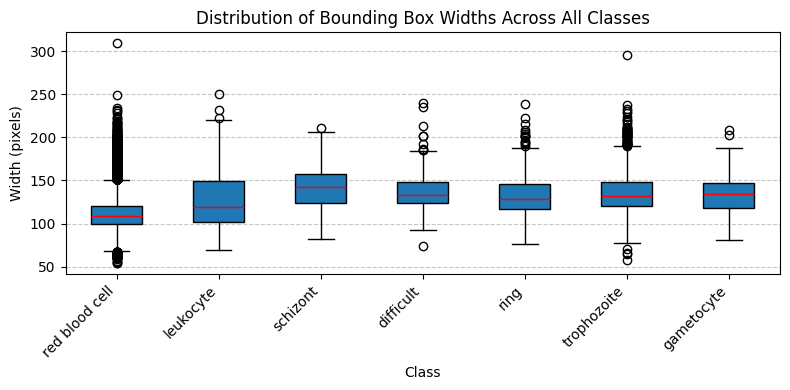

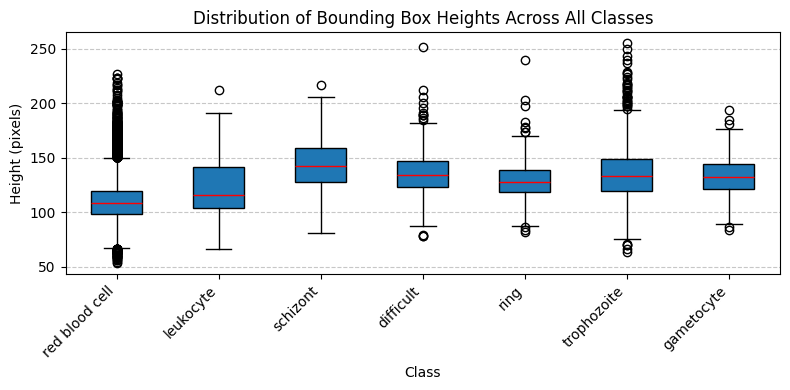

Comparative box plots for bounding box widths and heights generated.


In [17]:
# Visual representations of the size distributions to enable direct comparison with the 'difficult' class.
# Prepare data for plotting
# We need a list of lists for boxplot, where each inner list contains dimensions for one class
# And a corresponding list of class names for labels

# Ensure classes are in a consistent order (e.g., sorted by ID)
sorted_class_ids = sorted(all_classes_bbox_dimensions.keys())

all_widths_for_plot = []
all_heights_for_plot = []
class_names_for_plot = []

for class_id in sorted_class_ids:
    dimensions_list = all_classes_bbox_dimensions[class_id]
    if dimensions_list:
        widths = [dim[0] for dim in dimensions_list]
        heights = [dim[1] for dim in dimensions_list]
        all_widths_for_plot.append(widths)
        all_heights_for_plot.append(heights)
        class_names_for_plot.append(id_to_category.get(class_id, f'Unknown_Class_{class_id}'))

# Generate box plot for widths
plt.figure(figsize=(8, 4))
plt.boxplot(all_widths_for_plot, tick_labels=class_names_for_plot, patch_artist=True, medianprops=dict(color='red'))
plt.title('Distribution of Bounding Box Widths Across All Classes')
plt.xlabel('Class')
plt.ylabel('Width (pixels)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Generate box plot for heights
plt.figure(figsize=(8, 4))
plt.boxplot(all_heights_for_plot, tick_labels=class_names_for_plot, patch_artist=True, medianprops=dict(color='red'))
plt.title('Distribution of Bounding Box Heights Across All Classes')
plt.xlabel('Class')
plt.ylabel('Height (pixels)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Comparative box plots for bounding box widths and heights generated.")

**Interpretation of analysis of bounding box dimensions for all classes**

***Boxplot of Bounding Box Widths***
- “Difficult” overlaps almost perfectly with trophozoite in width distribution
- Both show similar medians and interquartile ranges.
- Ring and schizont are more distinct, with ring being slightly smaller and schizont slightly larger.

***Boxplot of Bounding Box Heights***
- “Difficult” class height distribution is nearly identical to trophozoite.
- Median, interquartile range, and overall spread are aligned.
- Ring, schizont, & leukocyte show distinct distributions.

--------------------

### **Overall Recommendation for handling 'Difficult' class**

Based on distribution of difficult class in the 3 image subsets, co_occurence analysis of difficult class with other classes and analysis of bounding box dimensions, the difficult class annotations will be merged with the trophozoite class. This is because of:

1.   Difficult class to be removed as train images that contain this class most likely contain 1 instance. This can be achieved by merging with trophozoite class explained previously.
2. For validation & test subset, difficult class has very low representation and will not affect metrics if removed.
3.  Trophozoite appears in nearly 50% of training images with “difficult”, far more than any other class.(50% overlap)
4.   Ring, schizont & gametocyte trail behind in coccurence, reinforcing trophozoite as the dominant contextual neighbor.
5. Confusion matrix shows 43 misclassifications from “difficult” to trophozoite.
6. 'Difficult' class bounding box dimensions are most similar to Trophozoite class. Mean width/height for “difficult” (136 px) is nearly identical to trophozoite (135 px). Hence difficult” is not a distinct morphological class, but overlaps with trophozoite.


Merge “Difficult” into Trophozoite
Why this works:
- Biologically plausible: both represent intraerythrocytic stages.
- Statistically supported: highest co-occurrence and confusion.
- Minimizes data loss while simplifying class boundaries.
- The “difficult” class is not morphologically or spatially distinct. It likely represents labeler uncertainty around trophozoite-like forms.

Merging it into trophozoite will:
- Reduce confusion & false positives (low precision).
- Improve precision, recall and mAP for parasite detection
- Preserve data without introducing noise.
- Reduce label noise
- simplify class boundaries
---------------------------

## 4.2 Create folder for dataset with no 'Difficult' class

In [19]:
import os

malaria_data_dir = '/content/drive/MyDrive/'

# Define the new folder name
new_finetune_folder = 'yolov8_malaria_finetune'

# Construct the full path for the new folder
finetune_path = os.path.join(malaria_data_dir, new_finetune_folder)

# Create the directory if it doesn't exist
try:
    os.makedirs(finetune_path, exist_ok=True)
    print(f"Folder '{new_finetune_folder}' created successfully at: {finetune_path}")
except Exception as e:
    print(f"Error creating folder: {e}")


Folder 'yolov8_malaria_finetune' created successfully at: /content/drive/MyDrive/yolov8_malaria_finetune


### 4.2.1 Copy image & labels folder from yolov8_malaria_dataset

In [20]:
import os
import shutil

# Copy image & labels folders from yolov8_malaria_dataset to yolov8_malaria_finetune.

# Define source and destination root directories
malaria_dataset_dir = '/content/drive/MyDrive/yolov8_malaria_dataset'
finetune_path = '/content/drive/MyDrive/yolov8_malaria_finetune'

# Define the subfolders to copy
folders_to_copy = ['images', 'labels']

print(f"Copying folders from {malaria_dataset_dir} to {finetune_path}...")

for folder_name in folders_to_copy:
    source_folder = os.path.join(malaria_dataset_dir, folder_name)
    destination_folder = os.path.join(finetune_path, folder_name)

    if os.path.exists(source_folder):
        # Remove destination folder if it already exists to ensure a clean copy
        if os.path.exists(destination_folder):
            print(f"  Removing existing {destination_folder}...")
            shutil.rmtree(destination_folder)

        print(f"  Copying {source_folder} to {destination_folder}...")
        try:
            shutil.copytree(source_folder, destination_folder)
            print(f"  Successfully copied {folder_name}.")
        except Exception as e:
            print(f"  Error copying {folder_name}: {e}")
    else:
        print(f"  Warning: Source folder not found: {source_folder}. Skipping {folder_name}.")

print("✅ Copy operation complete.")


Copying folders from /content/drive/MyDrive/yolov8_malaria_dataset to /content/drive/MyDrive/yolov8_malaria_finetune...
  Copying /content/drive/MyDrive/yolov8_malaria_dataset/images to /content/drive/MyDrive/yolov8_malaria_finetune/images...
  Successfully copied images.
  Copying /content/drive/MyDrive/yolov8_malaria_dataset/labels to /content/drive/MyDrive/yolov8_malaria_finetune/labels...
  Successfully copied labels.
✅ Copy operation complete.


### 4.2.2 Copy data.yaml file from yolov8_malaria_dataset to yolov8_malaria_finetune.

In [21]:
# Copy data.yaml file from yolov8_malaria_dataset to yolov8_malaria_finetune.
import os
import shutil

# Define source and destination root directories
malaria_dataset_dir = '/content/drive/MyDrive/yolov8_malaria_dataset'
finetune_path = '/content/drive/MyDrive/yolov8_malaria_finetune'

# Define the source and destination paths for data.yaml
source_data_yaml = os.path.join(malaria_dataset_dir, 'data.yaml')
destination_data_yaml = os.path.join(finetune_path, 'data.yaml')

print(f"Copying {source_data_yaml} to {destination_data_yaml}...")

try:
    shutil.copy2(source_data_yaml, destination_data_yaml)
    print("✅ data.yaml copied successfully.")
except FileNotFoundError:
    print(f"❌ Error: Source file not found at {source_data_yaml}")
except Exception as e:
    print(f"❌ Error copying data.yaml: {e}")


Copying /content/drive/MyDrive/yolov8_malaria_dataset/data.yaml to /content/drive/MyDrive/yolov8_malaria_finetune/data.yaml...
✅ data.yaml copied successfully.


## 4.3 Backing up original label files.

In [22]:
from pathlib import Path #

# --- CONFIGURATION ---
dataset_root='/content/drive/MyDrive/yolov8_malaria_finetune'

# Define original label directories
LABELS_DIRS = [
    os.path.join(dataset_root, 'labels/training'),
    os.path.join(dataset_root, 'labels/val'),
    os.path.join(dataset_root, 'labels/test')
]

# Backup directory
BACKUP_DIR = os.path.join(dataset_root, 'labels_backup_original')
os.makedirs(BACKUP_DIR, exist_ok=True)
print(f"Created backup directory: {BACKUP_DIR}")

# Copy label files to backup directory
for labels_dir in LABELS_DIRS:
    subset_name = Path(labels_dir).name
    backup_subset_path = os.path.join(BACKUP_DIR, subset_name)
    os.makedirs(backup_subset_path, exist_ok=True)

    if os.path.exists(labels_dir):
        print(f"Backing up labels from {labels_dir} to {backup_subset_path}...")
        count = 0
        for label_file_name in os.listdir(labels_dir):
            if label_file_name.endswith('.txt'):
                source_path = os.path.join(labels_dir, label_file_name)
                destination_path = os.path.join(backup_subset_path, label_file_name)
                shutil.copy2(source_path, destination_path)  # preserves metadata
                count += 1
        print(f"  {count} label files backed up for {subset_name}.")
    else:
        print(f"Warning: Labels directory not found at {labels_dir}. Skipping backup.")

print("✅ Original label files successfully backed up.")


Created backup directory: /content/drive/MyDrive/yolov8_malaria_finetune/labels_backup_original
Backing up labels from /content/drive/MyDrive/yolov8_malaria_finetune/labels/training to /content/drive/MyDrive/yolov8_malaria_finetune/labels_backup_original/training...
  825 label files backed up for training.
Backing up labels from /content/drive/MyDrive/yolov8_malaria_finetune/labels/val to /content/drive/MyDrive/yolov8_malaria_finetune/labels_backup_original/val...
  206 label files backed up for val.
Backing up labels from /content/drive/MyDrive/yolov8_malaria_finetune/labels/test to /content/drive/MyDrive/yolov8_malaria_finetune/labels_backup_original/test...
  120 label files backed up for test.
✅ Original label files successfully backed up.


## 4.4 Remappings class ID 3 (“Difficult”) to 5 (“Trophozoite”).

In [23]:
import os
from pathlib import Path

# --- CONFIGURATION ---
dataset_root='/content/drive/MyDrive/yolov8_malaria_finetune'
LABELS_DIRS = [
    os.path.join(dataset_root, 'labels/training'),
    os.path.join(dataset_root, 'labels/val'),
    os.path.join(dataset_root, 'labels/test')
]

# --- CLASS MAPPING ---
# Original IDs (from data.yaml):
# 0: red blood cell
# 1: leukocyte
# 2: schizont
# 3: difficult
# 4: ring
# 5: trophozoite
# 6: gametocyte
#
# Strategy: Merge "difficult" (3) into "trophozoite" (5)
# Reindex gametocyte to 4, ring to 3
CLASS_REMAP = {
    0: 0,  # red blood cell
    1: 1,  # leukocyte
    2: 2,  # schizont
    3: 5,  # difficult → trophozoite
    4: 3,  # ring → ring (reindexed to 3)
    5: 5,  # trophozoite
    6: 4   # gametocyte → reindexed to 4
}

def remap_labels():
    """Remap class IDs in YOLO label files"""
    total_files, total_remapped = 0, 0

    for labels_dir in LABELS_DIRS:
        if not os.path.exists(labels_dir):
            print(f"⚠️ Directory not found: {labels_dir}")
            continue

        label_files = list(Path(labels_dir).glob('*.txt'))
        print(f"\nProcessing {len(label_files)} files in {labels_dir}...")

        for label_file in label_files:
            remapped_lines = []
            file_modified = False

            with open(label_file, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:  # YOLO format: class_id x_center y_center width height
                    old_class = int(parts[0])
                    new_class = CLASS_REMAP.get(old_class, old_class)

                    if old_class != new_class:
                        file_modified = True
                        total_remapped += 1

                    parts[0] = str(new_class)
                    remapped_lines.append(' '.join(parts) + '\n')
                else:
                    remapped_lines.append(line)

            with open(label_file, 'w') as f:
                f.writelines(remapped_lines)

            total_files += 1

    print(f"\n✅ Remapping complete!")
    print(f"   Files processed: {total_files}")
    print(f"   Annotations remapped: {total_remapped}")

# --- RUN ---
print("=" * 60)
print("REMAPPING 'DIFFICULT' CLASS INTO 'TROPHOZOITE'")
print("=" * 60)

remap_labels()


REMAPPING 'DIFFICULT' CLASS INTO 'TROPHOZOITE'

Processing 825 files in /content/drive/MyDrive/yolov8_malaria_finetune/labels/training...

Processing 206 files in /content/drive/MyDrive/yolov8_malaria_finetune/labels/val...

Processing 120 files in /content/drive/MyDrive/yolov8_malaria_finetune/labels/test...

✅ Remapping complete!
   Files processed: 1151
   Annotations remapped: 1124


### 4.5 Count how many 'Difficult' annotations were merged per subset.

In [24]:
import os
from pathlib import Path

# --- CONFIGURATION ---
dataset_root='/content/drive/MyDrive/yolov8_malaria_finetune'
LABELS_DIRS = {
    'training': os.path.join(dataset_root, 'labels/training'),
    'val': os.path.join(dataset_root, 'labels/val'),
    'test': os.path.join(dataset_root, 'labels/test')
}

def summarize_merges():
    """Count how many 'difficult' annotations were merged per subset."""
    subset_summary = {}
    total = 0

    for subset_name, labels_dir in LABELS_DIRS.items():
        if not os.path.exists(labels_dir):
            print(f"⚠️ Directory not found: {labels_dir}")
            continue

        label_files = list(Path(labels_dir).glob('*.txt'))
        subset_count = 0

        for label_file in label_files:
            with open(label_file, 'r') as f:
                lines = f.readlines()

            # After remap, difficult (3) → trophozoite (5).
            # So we count how many lines were changed.
            # If you want to check pre-remap, look for '3'.
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    # Count how many were originally difficult
                    # If you saved a backup, you can compare old vs new.
                    # Here we assume remap done, so we count trophozoite (5) lines
                    # that came from difficult. If you want exact, compare with backup.
                    if int(parts[0]) == 5:
                        # This counts trophozoite lines (merged difficult + true trophozoite)
                        # To isolate only difficult merges, compare with backup files.
                        subset_count += 1

        subset_summary[subset_name] = subset_count
        total += subset_count

    print("\n📊 Summary per subset:")
    for subset, count in subset_summary.items():
        print(f"   {subset}: {count} merged annotations")
    print(f"\nTotal merged annotations: {total}")

# --- RUN ---
summarize_merges()


📊 Summary per subset:
   training: 1511 merged annotations
   val: 403 merged annotations
   test: 116 merged annotations

Total merged annotations: 2030


### 4.6 Compare backup vs remapped labels to count merged 'Difficult' annotations per subset.

In [25]:
import os
from pathlib import Path

# --- CONFIGURATION ---
dataset_root='/content/drive/MyDrive/yolov8_malaria_finetune'
LABELS_DIRS = {
    'training': os.path.join(dataset_root, 'labels/training'),
    'val': os.path.join(dataset_root, 'labels/val'),
    'test': os.path.join(dataset_root, 'labels/test')
}
# Ensure BACKUP_DIR is also accessible
BACKUP_DIR = os.path.join(dataset_root, 'labels_backup_original')

def summarize_difficult_merges():
    """Compare backup vs remapped labels to count merged 'difficult' annotations per subset."""
    subset_summary = {}
    total_merged = 0

    # Corrected: Use LABELS_DIRS instead of REMAPPED_DIRS
    for subset_name, remap_dir in LABELS_DIRS.items():
        backup_dir = os.path.join(BACKUP_DIR, subset_name)
        if not os.path.exists(remap_dir) or not os.path.exists(backup_dir):
            print(f"⚠️ Missing directory for {subset_name}, skipping...")
            continue

        remap_files = list(Path(remap_dir).glob('*.txt'))
        subset_count = 0

        for remap_file in remap_files:
            backup_file = Path(backup_dir) / remap_file.name
            if not backup_file.exists():
                continue

            # Count difficult annotations in backup
            with open(backup_file, 'r') as f:
                backup_lines = f.readlines()
            difficult_count = sum(1 for line in backup_lines if line.strip().split()[0] == '3')

            subset_count += difficult_count
            total_merged += difficult_count

        subset_summary[subset_name] = subset_count

    print("\n📊 Summary of 'difficult' merges per subset:")
    for subset, count in subset_summary.items():
        print(f"   {subset}: {count} annotations merged into trophozoite")
    print(f"\nTotal merged across all subsets: {total_merged}")

# --- RUN ---
summarize_difficult_merges()


📊 Summary of 'difficult' merges per subset:
   training: 345 annotations merged into trophozoite
   val: 96 annotations merged into trophozoite
   test: 5 annotations merged into trophozoite

Total merged across all subsets: 446


## 4.7 Adjusting class weights for retraining.

#### 4.7.1 Define New Class Mappings



In [26]:
# Define New Class Mappings
# Define the updated `category_to_id` and `id_to_category` mappings to reflect the remapping of the 'difficult' class (ID 3) into 'trophozoite' (ID 5),
# and the reindexing of 'ring' and 'gametocyte' classes to accommodate the removal of 'difficult'.

from pprint import pprint

# 1. Define the category_to_id dictionary with the new class mappings
category_to_id = {
    'red blood cell': 0,
    'leukocyte': 1,
    'schizont': 2,
    'ring': 3,          # reindexed from 4
    'gametocyte': 4,    # reindexed from 6
    'trophozoite': 5    # includes original trophozoite and merged 'difficult'
}

# 2. Create the id_to_category dictionary by reversing the category_to_id mapping
id_to_category = {v: k for k, v in category_to_id.items()}

# 3. Print the category_to_id mapping
print("\nUpdated category_to_id mapping:")
pprint(category_to_id)

# 4. Print the id_to_category mapping
print("\nUpdated id_to_category mapping:")
pprint(id_to_category)

# 5. Update the global all_classes list by sorting the keys (category names) from the new category_to_id dictionary
all_classes = sorted(list(category_to_id.keys()))

# 6. Print the updated all_classes list
print("\nUpdated all_classes list:")
pprint(all_classes)


Updated category_to_id mapping:
{'gametocyte': 4,
 'leukocyte': 1,
 'red blood cell': 0,
 'ring': 3,
 'schizont': 2,
 'trophozoite': 5}

Updated id_to_category mapping:
{0: 'red blood cell',
 1: 'leukocyte',
 2: 'schizont',
 3: 'ring',
 4: 'gametocyte',
 5: 'trophozoite'}

Updated all_classes list:
['gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']


#### 4.7.2 Get Class Counts from Remapped Label Files


Create a function to read the .txt label files from the 'training', 'val', and 'test' directories. This function will count the occurrences of each class ID based on the updated class mapping and return the counts, percentages, and total annotations for each subset.

**Reasoning**:
The subtask requires defining a function `get_remapped_class_counts` to analyze the class distribution across the training, validation, and test sets after the class remapping. This function will count class occurrences, calculate percentages, and total annotations. After defining the function, it will be called and its results printed.



In [27]:
from collections import defaultdict
import os

def get_remapped_class_counts(labels_dirs, id_to_category):
    """
    Counts the occurrences of each class ID in label files for given subsets,
    calculates percentages, and total annotations.

    Args:
        labels_dirs (dict): A dictionary where keys are subset names (e.g., 'training', 'val', 'test')
                            and values are the corresponding label directory paths.
        id_to_category (dict): A mapping from class ID (int) to class name (str).

    Returns:
        tuple: (all_subset_counts, all_subset_percentages, all_subset_totals)
               - all_subset_counts (dict): {subset_name: {class_id: count}}
               - all_subset_percentages (dict): {subset_name: {class_id: percentage}}
               - all_subset_totals (dict): {subset_name: total_annotations}
    """
    all_subset_counts = {}
    all_subset_percentages = {}
    all_subset_totals = {}

    for subset_name, labels_dir_path in labels_dirs.items():
        if not os.path.exists(labels_dir_path):
            print(f"Warning: Label directory not found for {subset_name}: {labels_dir_path}. Skipping.")
            continue

        subset_class_counts = defaultdict(int)
        total_annotations_in_subset = 0

        for label_file_name in os.listdir(labels_dir_path):
            if label_file_name.endswith('.txt'):
                label_file_path = os.path.join(labels_dir_path, label_file_name)
                with open(label_file_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 0:
                            class_id = int(parts[0])
                            subset_class_counts[class_id] += 1
                            total_annotations_in_subset += 1

        subset_percentages = {}
        if total_annotations_in_subset > 0:
            for class_id, count in subset_class_counts.items():
                subset_percentages[class_id] = (count / total_annotations_in_subset) * 100

        all_subset_counts[subset_name] = dict(subset_class_counts) # Convert defaultdict to dict for cleaner storage
        all_subset_percentages[subset_name] = subset_percentages
        all_subset_totals[subset_name] = total_annotations_in_subset

    return all_subset_counts, all_subset_percentages, all_subset_totals

# Call the function with the remapped labels directories and updated id_to_category
remapped_class_counts, remapped_class_percentages, remapped_class_totals = get_remapped_class_counts(LABELS_DIRS, id_to_category)

print("\n--- Class Distribution After Remapping ---")
for subset_name in LABELS_DIRS.keys():
    print(f"\nSubset: {subset_name.capitalize()}")
    if subset_name not in remapped_class_counts:
        print("  No data available for this subset.")
        continue

    print(f"  Total Annotations: {remapped_class_totals[subset_name]}")
    print("  Class Counts and Percentages:")

    # Sort by class ID for consistent output
    sorted_class_ids = sorted(remapped_class_counts[subset_name].keys())
    for class_id in sorted_class_ids:
        class_name = id_to_category.get(class_id, f"Unknown_ID_{class_id}")
        count = remapped_class_counts[subset_name].get(class_id, 0)
        percentage = remapped_class_percentages[subset_name].get(class_id, 0.0)
        print(f"    - {class_name} (ID {class_id}): {count} ({percentage:.2f}%)")


--- Class Distribution After Remapping ---

Subset: Training
  Total Annotations: 54331
  Class Counts and Percentages:
    - red blood cell (ID 0): 52192 (96.06%)
    - leukocyte (ID 1): 84 (0.15%)
    - schizont (ID 2): 137 (0.25%)
    - ring (ID 3): 286 (0.53%)
    - gametocyte (ID 4): 121 (0.22%)
    - trophozoite (ID 5): 1511 (2.78%)

Subset: Val
  Total Annotations: 14083
  Class Counts and Percentages:
    - red blood cell (ID 0): 13529 (96.07%)
    - leukocyte (ID 1): 19 (0.13%)
    - schizont (ID 2): 42 (0.30%)
    - ring (ID 3): 67 (0.48%)
    - gametocyte (ID 4): 23 (0.16%)
    - trophozoite (ID 5): 403 (2.86%)

Subset: Test
  Total Annotations: 5922
  Class Counts and Percentages:
    - red blood cell (ID 0): 5614 (94.80%)
    - schizont (ID 2): 11 (0.19%)
    - ring (ID 3): 169 (2.85%)
    - gametocyte (ID 4): 12 (0.20%)
    - trophozoite (ID 5): 116 (1.96%)


#### 4.7.3 Display and Visualize Updated Class Distribution


Print a detailed summary of the class counts and percentages for the training, validation, and test sets after the remapping. Additionally, generate comparative horizontal bar plots to visualize the updated class distribution, showing counts and percentages for each subset.

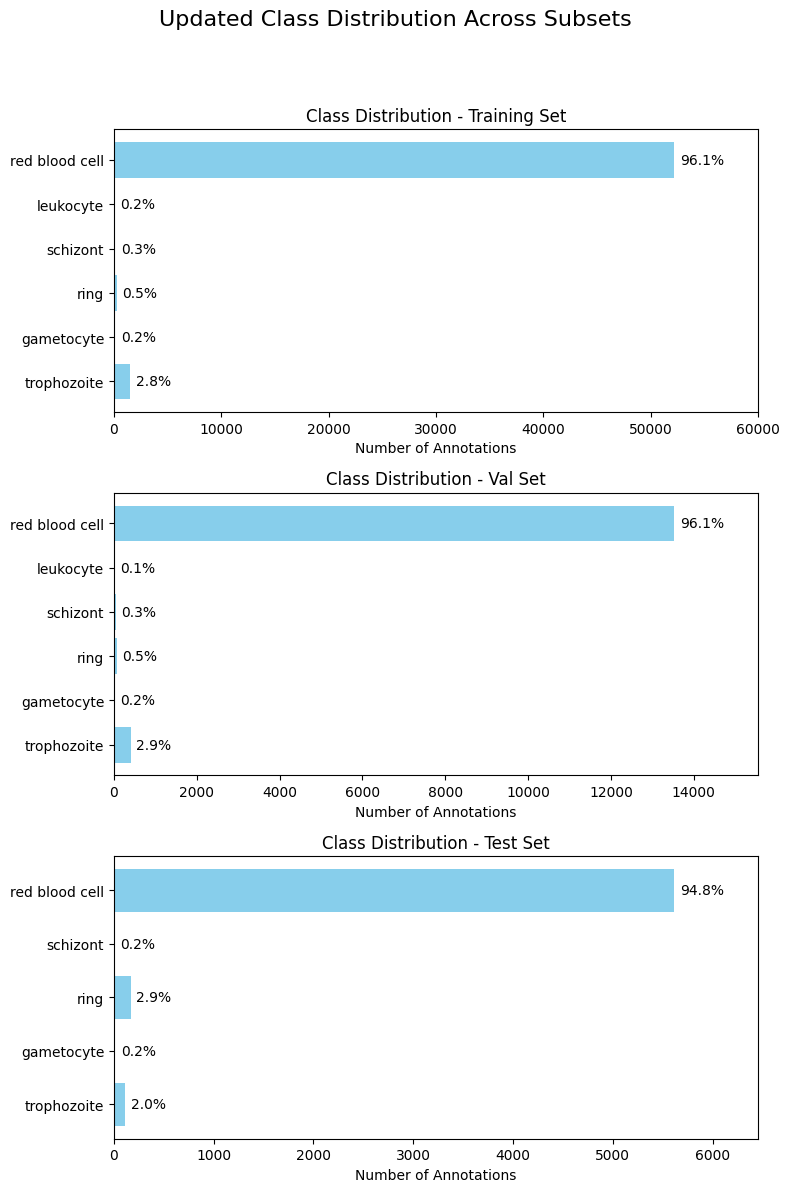

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
subsets = ['training', 'val', 'test']
fig, axes = plt.subplots(len(subsets), 1, figsize=(8,4 * len(subsets)))
fig.suptitle('Updated Class Distribution Across Subsets', fontsize=16, y=1.02)

if len(subsets) == 1: # Handle case with a single subplot (axes is not an array)
    axes = [axes]

for i, subset_name in enumerate(subsets):
    ax = axes[i]

    if subset_name not in remapped_class_counts:
        ax.text(0.5, 0.5, f"No data available for {subset_name.capitalize()}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Class Distribution - {subset_name.capitalize()} Set')
        ax.axis('off')
        continue

    # Get data for the current subset
    class_counts = remapped_class_counts[subset_name]
    class_percentages = remapped_class_percentages[subset_name]

    # Sort classes by ID for consistent plotting order
    sorted_class_ids = sorted(class_counts.keys())
    class_names = [id_to_category.get(cid, f'Unknown_ID_{cid}') for cid in sorted_class_ids]
    counts = [class_counts.get(cid, 0) for cid in sorted_class_ids]
    percentages = [class_percentages.get(cid, 0.0) for cid in sorted_class_ids]

    y_pos = np.arange(len(class_names))
    ax.barh(y_pos, counts, align='center', color='skyblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(class_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of Annotations')
    ax.set_title(f'Class Distribution - {subset_name.capitalize()} Set')

    # Add percentage labels to the bars
    for k, v in enumerate(counts):
        ax.text(v + (max(counts)*0.01 if max(counts) > 0 else 0.5), k, f'{percentages[k]:.1f}%', va='center')

    # Adjust x-axis limit for labels if necessary
    if counts:
        ax.set_xlim(right=max(counts) * 1.15) # Give some space for percentage labels

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()


### 4.7.4 Calculate class weights

In [30]:
import torch
import csv
import os
from datetime import datetime

def calculate_class_weights(class_counts, category_to_id, normalize=True, device="cpu", log_path=None):
    """
    Calculate inverse-frequency class weights for YOLOv8 training and optionally log to CSV.

    Args:
        class_counts (dict): Mapping class name -> count
        category_to_id (dict): Mapping class name -> YOLOv8 ID
        normalize (bool): Normalize weights to mean = 1
        device (str): 'cpu' or 'cuda'
        log_path (str): Optional path to save CSV log

    Returns:
        torch.Tensor: Ordered class weights tensor for YOLOv8
    """
    # Convert class_counts to use class names as keys for easier lookup
    # The remapped_class_counts['training'] returns class_id: count, so we need to map it back to name: count
    class_counts_by_name = {id_to_category[cid]: count for cid, count in class_counts.items()}

    total_samples = sum(class_counts_by_name.values())
    num_classes = len(category_to_id)

    # Calculate inverse frequency weights
    raw_weights = {}
    for cls_name, cls_id in category_to_id.items(): # Iterate by ordered class names
        count = class_counts_by_name.get(cls_name, 0)
        if count > 0:
            # Inverse of the frequency: (total_samples / num_classes) / count
            # This makes smaller classes have higher weights
            weight = (total_samples / num_classes) / count # Adjusted for total classes
        else:
            weight = total_samples  # very large weight if class absent to penalize false negatives
        raw_weights[cls_name] = weight

    # Normalize weights (optional) to ensure they sum to 'num_classes' or have a mean of 1
    normalized_weights = raw_weights.copy()
    if normalize:
        # Sum of raw weights before normalization
        sum_raw_weights = sum(raw_weights.values())
        if sum_raw_weights > 0:
             # Normalize such that the average weight is 1.0
            mean_raw_weight = sum_raw_weights / num_classes
            normalized_weights = {cls: w / mean_raw_weight for cls, w in raw_weights.items()}
        else:
            # Handle case where all raw weights are zero (e.g., no samples)
            normalized_weights = {cls: 1.0 for cls in category_to_id.keys()}

    # Order weights by category_to_id values (YOLOv8 class IDs)
    # The category_to_id provides the correct order for the final tensor
    ordered_weights = [
        normalized_weights[cls_name]
        for cls_name in sorted(category_to_id.keys(), key=lambda k: category_to_id[k])
    ]
    weights_tensor = torch.tensor(ordered_weights, dtype=torch.float32, device=device)

    # --- Logging to CSV ---
    if log_path:
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        # Check if the file exists and is empty to write header
        file_exists = os.path.exists(log_path)
        with open(log_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            if not file_exists or os.stat(log_path).st_size == 0:
                writer.writerow(["timestamp", "class_name", "class_id", "count", "raw_weight", "normalized_weight"])
            timestamp = datetime.now().isoformat(timespec='seconds')
            for cls_name, cls_id in category_to_id.items():
                writer.writerow([
                    timestamp,
                    cls_name,
                    cls_id,
                    class_counts_by_name.get(cls_name, 0),
                    raw_weights.get(cls_name, 0.0),
                    normalized_weights.get(cls_name, 1.0)
                ])
        print(f"📄 Class weights logged to {log_path}")

    return weights_tensor

#### 4.7.4.1 Call function to calculate class weights

In [33]:
# Use the training set class counts obtained after remapping
# remapped_class_counts and category_to_id should be available from previous cells
class_counts_for_weights = remapped_class_counts['training']

# Calculate and log weights
weights = calculate_class_weights(
    class_counts_for_weights,
    category_to_id,
    normalize=True,
    device='cpu',
    log_path='/content/drive/MyDrive/yolov8_malaria_finetune/class_weights_summary.csv'
)

print("Final class weights:", weights)

📄 Class weights logged to /content/drive/MyDrive/yolov8_malaria_finetune/class_weights_summary.csv
Final class weights: tensor([0.0036, 2.2571, 1.3839, 0.6629, 1.5669, 0.1255])


## 4.6 Updating data.yaml to reflect 6 classes

In [32]:
import yaml
import os

dataset_root='/content/drive/MyDrive/yolov8_malaria_finetune'

# Define the path to the data.yaml file
data_yaml_path = os.path.join(dataset_root, 'data.yaml')

# Construct the class names list in the correct order based on category_to_id
# category_to_id = {'red blood cell': 0, 'leukocyte': 1, 'schizont': 2, 'ring': 3, 'gametocyte': 4, 'trophozoite': 5}
# weights is a torch.Tensor, convert to list for YAML serialization

# Sort class names by their IDs to ensure correct order in data.yaml
sorted_class_names = [name for name, id in sorted(category_to_id.items(), key=lambda item: item[1])]

# Convert weights tensor to a Python list for YAML serialization
weights_list = weights.tolist()

data_yaml_content = {
    'path': dataset_root,  # Root path to the dataset
    'train': 'images/training', # Relative path to training images
    'val': 'images/val',     # Relative path to validation images
    'test': 'images/test',     # Relative path to test images
    'nc': len(category_to_id), # Number of classes
    'names': sorted_class_names, # List of class names
    'weights': weights_list  # Calculated class weights
}

# Write the dictionary to a YAML file
try:
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_yaml_content, f, sort_keys=False) # sort_keys=False to preserve order of names
    print(f"✅ data.yaml created successfully at: {data_yaml_path}")
    print("Content:")
    with open(data_yaml_path, 'r') as f:
        print(f.read())
except Exception as e:
    print(f"❌ Error creating data.yaml: {e}")

✅ data.yaml created successfully at: /content/drive/MyDrive/yolov8_malaria_finetune/data.yaml
Content:
path: /content/drive/MyDrive/yolov8_malaria_finetune
train: images/training
val: images/val
test: images/test
nc: 6
names:
- red blood cell
- leukocyte
- schizont
- ring
- gametocyte
- trophozoite
weights:
- 0.0036326944828033447
- 2.2571141719818115
- 1.3839240074157715
- 0.6629286408424377
- 1.5669221878051758
- 0.12547822296619415

